# Importing the libraries

In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input, Cropping2D, MaxPool2D,UpSampling2D
from keras.layers import Conv2D         
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

import tensorflow as tf

from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from datetime import datetime
from collections import deque 


from keras.models import load_model
from numpy.random import randint
from numpy import vstack


2024-03-02 10:39:36.334172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 10:39:37.146529: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 10:39:38.655580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/aranyaa/anaconda3/envs/capstone/lib/
2024-03-02 10:39:38.655714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.is_gpu_available()

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-03-02 10:39:40.518319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:39:40.583660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:39:40.583908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:39:40.592424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

True

2024-03-02 10:39:40.596439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:39:40.596775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:39:40.597007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:39:41.829985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:39:41.831295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

# Data preprocessing


- train dataset: 4515
- train2 dataset: 2000
- train3 dataset: 1000
- test dataset: 1255
- val dataset: 502

In [7]:
#Resizing the images
SIZE_X = 256
SIZE_Y = 256
n_classes = 6

In [4]:
#Capture segmented scans info as a list
seg_images = []

for directory_path in glob.glob("/home/aranyaa/Project/dataset_not_normalized/temp_train/ground_truths"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        try: 
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)       
            img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  
            img = img[...,None]
            seg_images.append(img)
        except Exception as e:
            print(img_path)

#Convert list to array for machine learning processing        
seg_images = np.array(seg_images)

#Capture brain scans info as a list
src_images = [] 
for directory_path in glob.glob("/home/aranyaa/Project/dataset_not_normalized/temp_train/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        try: 
            img = cv2.imread(img_path)  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      
            img = cv2.resize(img, (SIZE_Y, SIZE_X))  
            img = img[...,None]
            src_images.append(img)
        except Exception as e:
            print(img_path)
        
#Convert list to array for machine learning processing          
src_images = np.array(src_images)

print(np.unique(src_images))
print(np.unique(seg_images))
seg_images = seg_images * 255
print(np.unique(seg_images))
print(src_images[0].shape)
print(seg_images[0].shape)


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

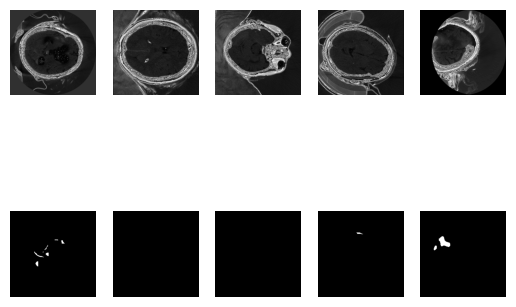

In [5]:
n_samples = 5
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(src_images[i], cmap='gray')
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(seg_images[i], cmap='gray')	
plt.show()

# Defining Functions

## Defining the discriminator

- C64-C128-C256-C512
- After the last layer, a convolution is applied to map to a 1-dimensional output, followed by a Sigmoid function.
- Can be thought of as a binary classifier that classifies the images as real or fake (1 or 0 respectively)

/home/aranyaa/anaconda3/envs/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


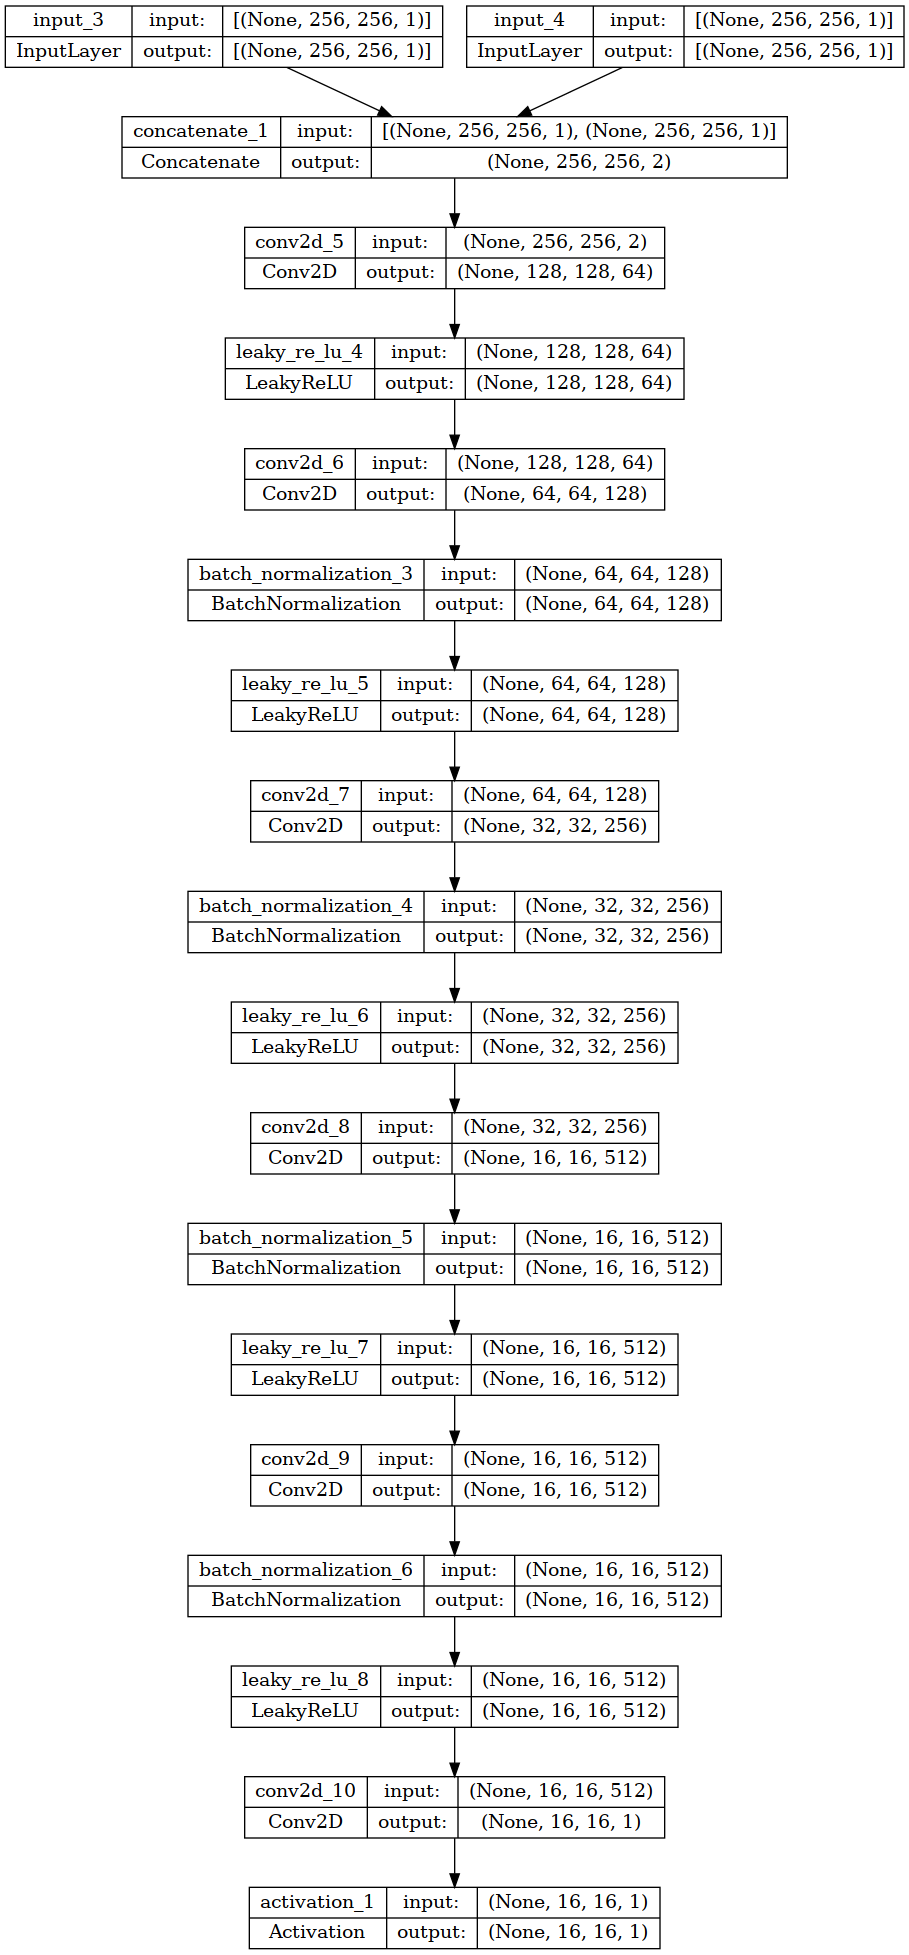

In [7]:
def define_discriminator(image_shape=(256,256,1)):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.1)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.1)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.1)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.1)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('linear')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt. 
    #with a small learning rate and 0.5 beta. 
    #The loss for the discriminator is weighted by 50% for each model update.
    
	opt = Adam(learning_rate=0.0001, beta_1=0.3)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

disc_model = define_discriminator((256,256,1))
plot_model(disc_model, to_file='disc_model.png', show_shapes=True)


## Defining the generator 

- Encoder model: C64-C128-C256-C512-C512-C512-C512-C512
- Decoder model: CD512-CD512-CD512-C512-C256-C128-C64

### Defining encoder block 

In [7]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g


### Defining decoder block

In [8]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	# g = LeakyReLU(alpha=0.2)(g)
	return g


### Defining the dice coefficient loss function

In [9]:
def dice_coefficient_loss(y_true, y_pred, axis=(1, 2, 3), epsilon=1e-7):
    # Compute intersection and union for each class
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    
    # Compute Dice coefficient for each class
    dice = (2.0 * intersection + epsilon) / (union + epsilon)
    
    return dice

### Defining generator

/home/aranyaa/anaconda3/envs/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


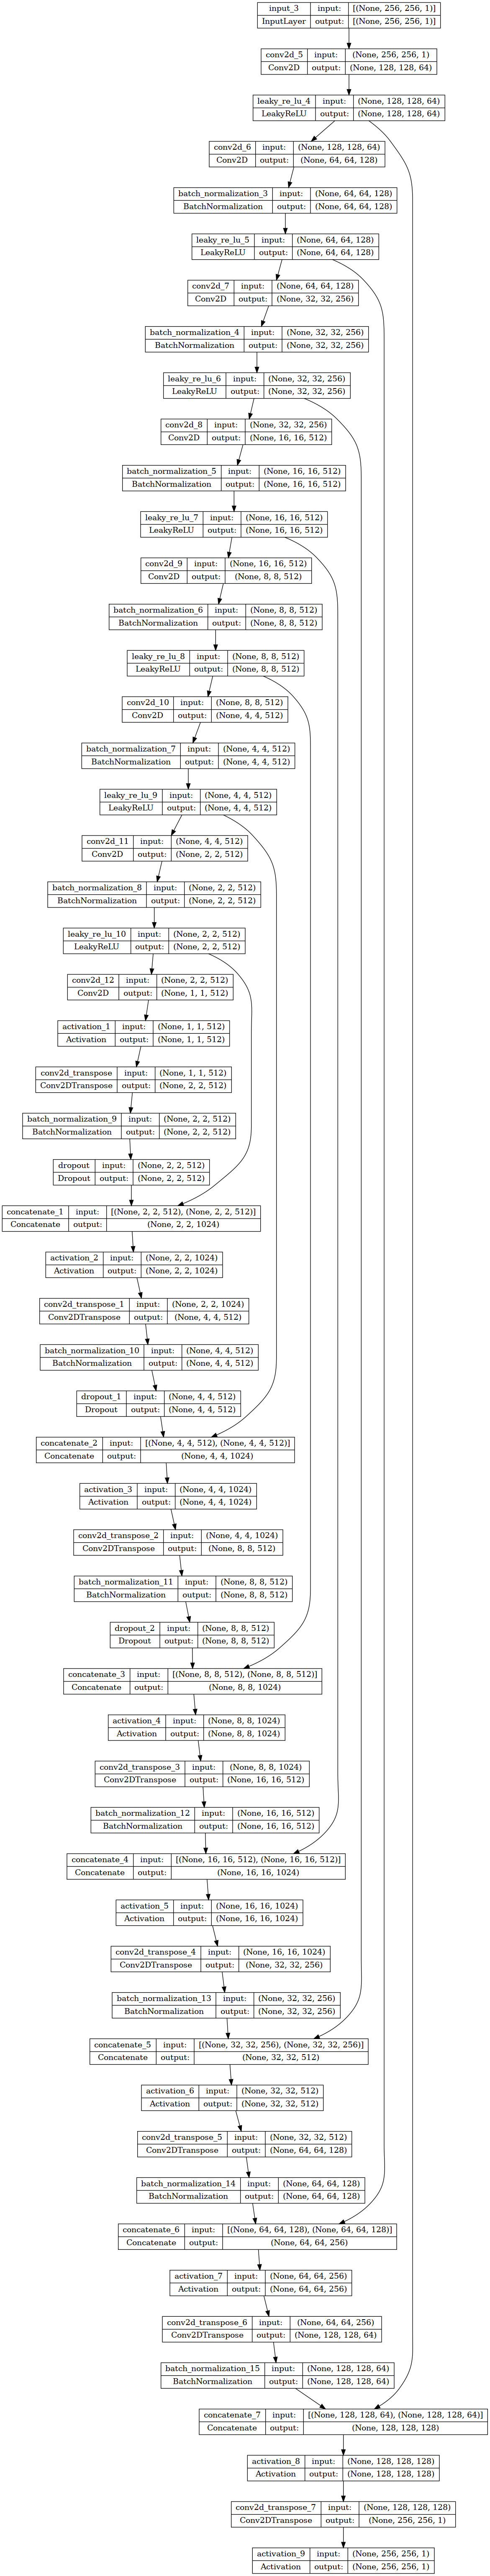

In [10]:
def define_generator(image_shape=(256,256,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# b = LeakyReLU(alpha=0.2)(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	# define model
	model = Model(in_image, out_image)
	#opt = Adam(learning_rate=0.001, beta_1=0.5)
	#model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[1])
	
	return model

gen_model = define_generator((256,256,1))
plot_model(gen_model, to_file='gen_model.png', show_shapes=True)



# Defining the GAN

In [11]:
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable.
            
	# define the source image
	in_src = Input(shape=image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0003, beta_1=0.5, beta_2= 0.99)
    
    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

# Defining the helper functions

In [12]:
# select a batch of random samples, returns images and target

def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [13]:
# generate a batch of images, returns images and targets

def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [14]:
# since GAN models don't converge we have to find a balance by summarizing performance

def summarize_performance(step, g_model, d_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'modelg_%06d.h5' % (step+1)
	filename3 = 'modeld_%06d.h5' % (step+1)
	g_model.save(filename2)
	d_model.save(filename3)
	print('>Saved: %s, %s and %s' % (filename1, filename2, filename3))

In [15]:
def plot_losses(d_loss1_buffer, d_loss2_buffer, g_loss_buffer):
    plt.plot(d_loss1_buffer, label='Discriminator Loss Real')
    plt.plot(d_loss2_buffer, label='Discriminator Loss Fake')
    plt.plot(g_loss_buffer, label='Generator Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Losses')
    plt.legend()
    plt.pause(0.01)  # Pause for a short time to update the plot

# Defining the train function

In [16]:
BUFFER_SIZE = 2000

In [17]:
# Define a function to save checkpoints
'''def save_checkpoint(epoch, logs, checkpoint_interval, checkpoint_dir, g_model, d_model):
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint_path = os.path.join(checkpoint_dir, 'weights_epoch_{}.h5'.format(epoch + 1))
        g_model.save_weights(checkpoint_path)
        #d_model.save_weights(checkpoint_path)
        print('Checkpoint saved at', checkpoint_path)'''

"def save_checkpoint(epoch, logs, checkpoint_interval, checkpoint_dir, g_model, d_model):\n    if (epoch + 1) % checkpoint_interval == 0:\n        checkpoint_path = os.path.join(checkpoint_dir, 'weights_epoch_{}.h5'.format(epoch + 1))\n        g_model.save_weights(checkpoint_path)\n        #d_model.save_weights(checkpoint_path)\n        print('Checkpoint saved at', checkpoint_path)"

In [18]:
def train(d_model, g_model, gan_model, dataset, n_epochs=50, n_batch=1, plot_interval = 10, checkpoint_interval = 10):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# Circular bufferes for plotting
	d_loss1_buffer = deque(maxlen=BUFFER_SIZE)
	d_loss2_buffer = deque(maxlen=BUFFER_SIZE)
	g_loss_buffer = deque(maxlen=BUFFER_SIZE)

	# Define the directory where checkpoints will be saved
	'''checkpoint_dir = '/home/aranyaa/Project/checkpoints'
	os.makedirs(checkpoint_dir, exist_ok=True)

	# Define the checkpoint callback
	checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'weights_epoch_{epoch:02d}.h5'),
        monitor='loss',  # Monitor loss
        save_weights_only=True,  # Save only the model's weights
        save_best_only=False,  # Save all models
        period=checkpoint_interval,  # Save checkpoint every 'checkpoint_interval' epochs
        verbose=1  # Verbosity mode. Set to 1 to see checkpoint saving messages
    )
'''
	# Define the LambdaCallback to save checkpoints
	# save_checkpoint_callback = LambdaCallback(on_epoch_end=save_checkpoint)
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# append losses into buffers
		d_loss1_buffer.append(d_loss1)
		d_loss2_buffer.append(d_loss2)
		g_loss_buffer.append(g_loss)
		# plot less frequently to save memory
		if (i+1) % (bat_per_epo * plot_interval) == 0:
			plot_losses(d_loss1_buffer, d_loss2_buffer, g_loss_buffer)
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# Save checkpoint at specified interval
		# save_checkpoint(i // bat_per_epo, None, checkpoint_interval, checkpoint_dir, g_model, d_model)
		# summarize model performance
		if (i+1) % (bat_per_epo * 2) == 0:
			summarize_performance(i, g_model, d_model, dataset)

# Setting up data for training

In [19]:
image_shape = src_images.shape[1:]
print(image_shape)
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)


(256, 256, 1)


/home/aranyaa/anaconda3/envs/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [20]:
#Define data
# load and prepare training images
dataset = [src_images, seg_images]
del src_images, seg_images

In [3]:
#Preprocess data to change input range to values between -1 and 1

#This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]


In [22]:
dataset = preprocess_data(dataset)

# Training the data

2024-02-27 16:09:23.910904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 3s 3s/step
>1, d1[2.711] d2[3.860] g[104.969]
1/1 [==============================] - 0s 20ms/step
>2, d1[2.466] d2[3.773] g[101.020]
1/1 [==============================] - 0s 20ms/step
>3, d1[2.210] d2[3.473] g[96.954]
1/1 [==============================] - 0s 21ms/step
>4, d1[2.493] d2[3.206] g[93.628]
1/1 [==============================] - 0s 24ms/step
>5, d1[2.383] d2[2.981] g[91.314]
1/1 [==============================] - 0s 23ms/step
>6, d1[2.984] d2[2.111] g[90.678]
1/1 [==============================] - 0s 22ms/step
>7, d1[2.843] d2[1.887] g[89.111]
1/1 [==============================] - 0s 21ms/step
>8, d1[2.822] d2[2.087] g[86.267]
1/1 [==============================] - 0s 21ms/step
>9, d1[2.955] d2[2.019] g[84.832]
1/1 [==============================] - 0s 22ms/step
>10, d1[2.920] d2[2.301] g[81.833]
1/1 [==============================] - 0s 21ms/step
>11, d1[2.991] d2[2.327] g[79.262]
1/1 [==============================] - 0s 22ms/step


2024-02-27 16:15:06.747961: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


>1987, d1[1.295] d2[3.451] g[2.560]
1/1 [==============================] - 0s 20ms/step
>1988, d1[0.881] d2[4.257] g[2.213]
1/1 [==============================] - 0s 21ms/step
>1989, d1[1.321] d2[3.563] g[4.783]
1/1 [==============================] - 0s 20ms/step
>1990, d1[0.977] d2[3.609] g[7.862]
1/1 [==============================] - 0s 22ms/step
>1991, d1[1.220] d2[3.295] g[2.457]
1/1 [==============================] - 0s 21ms/step
>1992, d1[1.185] d2[3.050] g[2.383]
1/1 [==============================] - 0s 21ms/step
>1993, d1[1.074] d2[3.050] g[3.019]
1/1 [==============================] - 0s 23ms/step
>1994, d1[1.299] d2[3.484] g[2.576]
1/1 [==============================] - 0s 21ms/step
>1995, d1[1.187] d2[3.472] g[2.505]
1/1 [==============================] - 0s 21ms/step
>1996, d1[0.654] d2[2.731] g[1.309]
1/1 [==============================] - 0s 21ms/step
>1997, d1[1.192] d2[3.284] g[2.367]
1/1 [==============================] - 0s 19ms/step
>1998, d1[1.527] d2[3.793] g[5.9

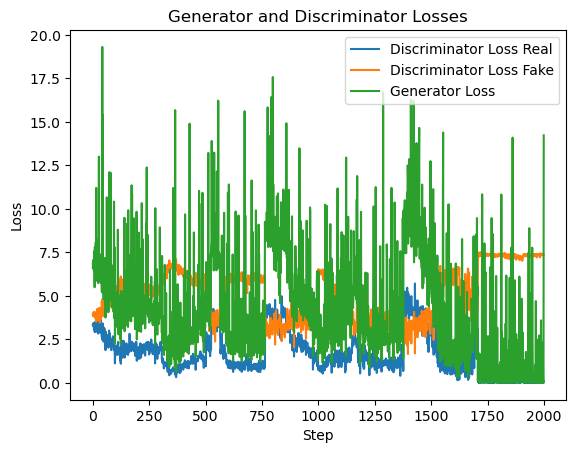

>2715, d1[0.090] d2[7.339] g[14.235]
1/1 [==============================] - 0s 28ms/step
>2716, d1[0.071] d2[7.299] g[3.944]
1/1 [==============================] - 0s 25ms/step
>2717, d1[0.013] d2[7.409] g[0.026]
1/1 [==============================] - 0s 24ms/step
>2718, d1[0.014] d2[7.390] g[0.027]
1/1 [==============================] - 0s 27ms/step
>2719, d1[0.009] d2[7.394] g[0.019]
1/1 [==============================] - 0s 26ms/step
>2720, d1[0.025] d2[7.391] g[0.065]
1/1 [==============================] - 0s 25ms/step
>2721, d1[0.020] d2[7.351] g[0.040]
1/1 [==============================] - 0s 26ms/step
>2722, d1[0.010] d2[7.393] g[0.021]
1/1 [==============================] - 0s 27ms/step
>2723, d1[0.012] d2[7.362] g[2.303]
1/1 [==============================] - 0s 28ms/step
>2724, d1[0.069] d2[7.289] g[0.139]
1/1 [==============================] - 0s 26ms/step
>2725, d1[0.022] d2[7.390] g[0.044]
1/1 [==============================] - 0s 26ms/step
>2726, d1[0.011] d2[7.335] g[1.

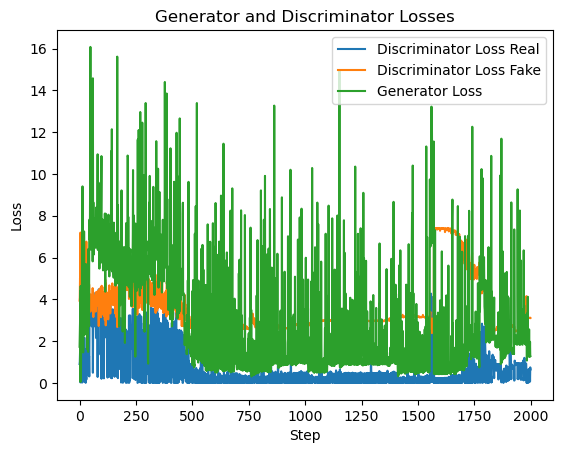

>5430, d1[0.644] d2[3.106] g[1.286]
1/1 [==============================] - 2s 2s/step
>Saved: plot_005430.png, modelg_005430.h5 and modeld_005430.h5
1/1 [==============================] - 0s 19ms/step
>5431, d1[0.017] d2[3.095] g[3.588]
1/1 [==============================] - 0s 21ms/step
>5432, d1[0.648] d2[3.016] g[1.330]
1/1 [==============================] - 0s 20ms/step
>5433, d1[0.273] d2[2.920] g[1.832]
1/1 [==============================] - 0s 21ms/step
>5434, d1[0.658] d2[2.928] g[1.310]
1/1 [==============================] - 0s 20ms/step
>5435, d1[0.653] d2[2.927] g[1.300]
1/1 [==============================] - 0s 19ms/step
>5436, d1[0.653] d2[2.929] g[1.300]
1/1 [==============================] - 0s 20ms/step
>5437, d1[0.498] d2[2.927] g[1.421]
1/1 [==============================] - 0s 21ms/step
>5438, d1[0.654] d2[2.927] g[1.305]
1/1 [==============================] - 0s 20ms/step
>5439, d1[0.653] d2[2.927] g[1.301]
1/1 [==============================] - 0s 20ms/step
>5440, 

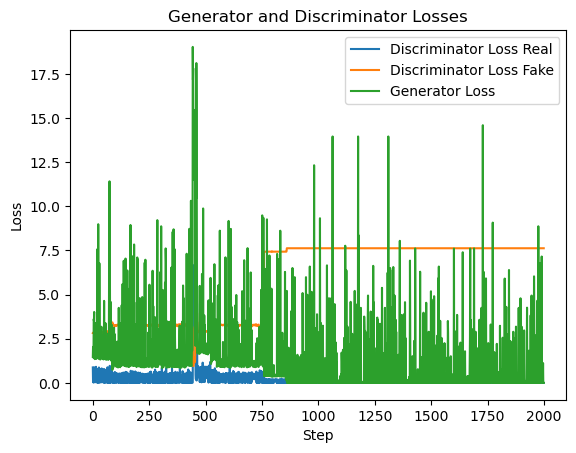

>8145, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 23ms/step
>8146, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 20ms/step
>8147, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 21ms/step
>8148, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 20ms/step
>8149, d1[0.000] d2[7.625] g[5.768]
1/1 [==============================] - 0s 19ms/step
>8150, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 21ms/step
>8151, d1[0.000] d2[7.625] g[2.835]
1/1 [==============================] - 0s 20ms/step
>8152, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 21ms/step
>8153, d1[0.000] d2[7.625] g[4.251]
1/1 [==============================] - 0s 20ms/step
>8154, d1[0.000] d2[7.625] g[1.682]
1/1 [==============================] - 0s 20ms/step
>8155, d1[0.000] d2[7.625] g[4.590]
1/1 [==============================] - 0s 20ms/step
>8156, d1[0.000] d2[7.625] g[0.0

2024-02-27 16:38:04.999282: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


>10051, d1[0.000] d2[7.625] g[2.820]
1/1 [==============================] - 0s 27ms/step
>10052, d1[0.000] d2[7.625] g[1.166]
1/1 [==============================] - 0s 29ms/step
>10053, d1[0.000] d2[7.625] g[4.245]
1/1 [==============================] - 0s 26ms/step
>10054, d1[0.000] d2[7.625] g[1.160]
1/1 [==============================] - 0s 24ms/step
>10055, d1[0.000] d2[7.625] g[0.177]
1/1 [==============================] - 0s 25ms/step
>10056, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 22ms/step
>10057, d1[0.000] d2[7.625] g[0.504]
1/1 [==============================] - 0s 29ms/step
>10058, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 26ms/step
>10059, d1[0.000] d2[7.625] g[0.171]
1/1 [==============================] - 0s 23ms/step
>10060, d1[0.000] d2[7.625] g[0.775]
1/1 [==============================] - 0s 23ms/step
>10061, d1[0.000] d2[7.625] g[0.665]
1/1 [==============================] - 0s 22ms/step
>10062, d1[0.000] d2[

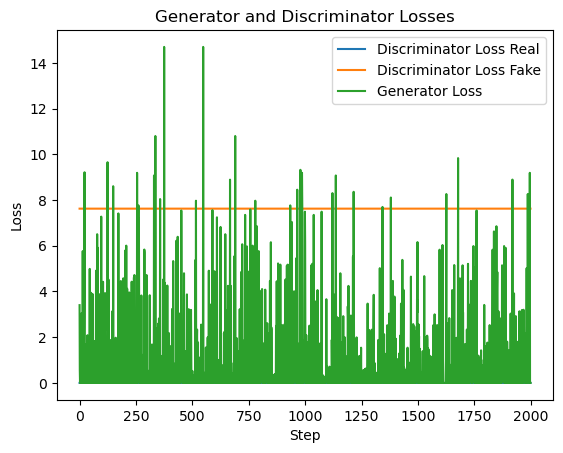

>10860, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 46ms/step
>Saved: plot_010860.png, modelg_010860.h5 and modeld_010860.h5
1/1 [==============================] - 0s 21ms/step
>10861, d1[0.000] d2[7.625] g[9.192]
1/1 [==============================] - 0s 20ms/step
>10862, d1[0.000] d2[7.625] g[4.990]
1/1 [==============================] - 0s 22ms/step
>10863, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 22ms/step
>10864, d1[0.000] d2[7.625] g[8.453]
1/1 [==============================] - 0s 21ms/step
>10865, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 20ms/step
>10866, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 22ms/step
>10867, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 21ms/step
>10868, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 21ms/step
>10869, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 22ms/

2024-02-27 16:45:29.826561: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


>12662, d1[0.000] d2[7.625] g[0.952]
1/1 [==============================] - 0s 19ms/step
>12663, d1[0.000] d2[7.625] g[1.593]
1/1 [==============================] - 0s 20ms/step
>12664, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 21ms/step
>12665, d1[0.000] d2[7.625] g[0.351]
1/1 [==============================] - 0s 19ms/step
>12666, d1[0.000] d2[7.625] g[0.235]
1/1 [==============================] - 0s 21ms/step
>12667, d1[0.000] d2[7.625] g[0.281]
1/1 [==============================] - 0s 22ms/step
>12668, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 22ms/step
>12669, d1[0.000] d2[7.625] g[2.780]
1/1 [==============================] - 0s 20ms/step
>12670, d1[0.000] d2[7.625] g[0.101]
1/1 [==============================] - 0s 19ms/step
>12671, d1[0.000] d2[7.625] g[4.660]
1/1 [==============================] - 0s 19ms/step
>12672, d1[0.000] d2[7.625] g[0.977]
1/1 [==============================] - 0s 19ms/step
>12673, d1[0.000] d2[

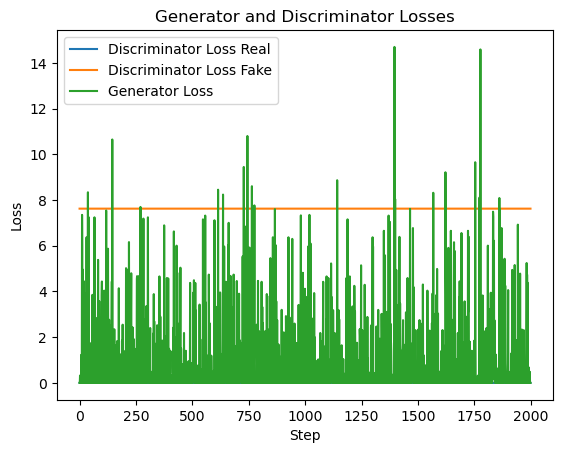

>13575, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 28ms/step
>13576, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 22ms/step
>13577, d1[0.000] d2[7.625] g[0.348]
1/1 [==============================] - 0s 20ms/step
>13578, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 20ms/step
>13579, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 21ms/step
>13580, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 21ms/step
>13581, d1[0.000] d2[7.625] g[0.302]
1/1 [==============================] - 0s 20ms/step
>13582, d1[0.000] d2[7.625] g[0.992]
1/1 [==============================] - 0s 20ms/step
>13583, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 20ms/step
>13584, d1[0.000] d2[7.625] g[4.425]
1/1 [==============================] - 0s 19ms/step
>13585, d1[0.000] d2[7.625] g[0.000]
1/1 [==============================] - 0s 19ms/step
>13586, d1[0.000] d2[

KeyboardInterrupt: 

In [23]:
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=15, n_batch=1, plot_interval=1) 

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

g_model.save('Brain_hemorrhage_detection_.h5')

# Testing trained model on a few images

In [4]:
model = load_model('/home/aranyaa/Project/modelg_010860.h5', compile=False)

2024-03-02 10:40:26.138044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:40:26.138537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:40:26.138803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:40:26.139209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-02 10:40:26.139533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [5]:
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	# scale from [-1,1] to [0,1]
	# images = (images + 1) / 2.0
	titles = ['Input-brain-scan', 'Segmented-Generated', 'Segmented-Original']
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		plt.subplot(1, 3, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i,:,:,0], cmap='gray')
		# show title
		plt.title(titles[i])
	plt.show()

In [8]:
#Capture segmented scans info as a list
seg_images_val = []

for directory_path in glob.glob("/home/aranyaa/Project/dataset_not_normalized/temp_val/ground_truths"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        try: 
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)       
            img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
            img = img[...,None]  
            seg_images_val.append(img)
        except Exception as e:
            print(str(e))

#Convert list to array for machine learning processing        
seg_images_val = np.array(seg_images_val)
seg_images_val = seg_images_val * 255

#Capture brain scans info as a list
src_images_val = [] 
for directory_path in glob.glob("/home/aranyaa/Project/dataset_not_normalized/temp_val/images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        try: 
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)       
            img = cv2.resize(img, (SIZE_Y, SIZE_X))
            img = img[...,None]  
            src_images_val.append(img)
        except Exception as e:
            print(str(e))
        
#Convert list to array for machine learning processing          
src_images_val = np.array(src_images_val)

val_dataset = [src_images_val, seg_images_val]
del src_images_val, seg_images_val

val_dataset = preprocess_data(val_dataset)




1/1 [==============================] - 0s 32ms/step


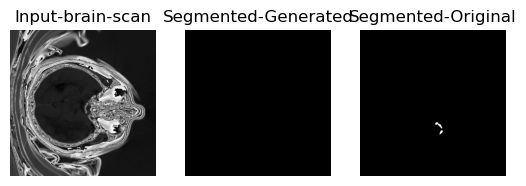

In [56]:
[X1, X2] = val_dataset 
# select random example
ix = randint(0, len(X1), 1)
src_image_val, seg_image_val = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image_val)
# plot all three images
plot_images(src_image_val, gen_image, seg_image_val)

In [44]:
print(np.unique(seg_image_val))
print(np.unique(gen_image))

[-1.  1.]
[-1.]
